#### Setting Up The Athena Driver

Jupyter Notebooks, like this one, provide a hybrid experience between interactive analytics and purpose built application development. You can leverage powerful statical analysis libraries like numpy or pandas and feed the results into pyplot or seaborn visualization libraries.


In [1]:
import sys
!{sys.executable} -m pip install PyAthena

  Using cached tenacity-7.0.0-py2.py3-none-any.whl (23 kB)


In [29]:
from pyathena import connect
import pandas as pd
conn = connect(work_group='packt-athena-analytics', region_name='us-east-1')

df = pd.read_sql("SELECT year, COUNT(*) from packt_serverless_analytics.chapter_3_nyc_taxi_parquet GROUP BY year", conn)
df
df.dtypes

year     float64
_col1      int64
dtype: object

<AxesSubplot:xlabel='year', ylabel='_col1'>

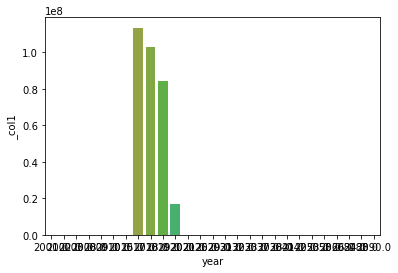

In [33]:
# Pandas for manipulating dataframes
import pandas as pd
# Matplotlib for inline graphs and plots
from matplotlib import pyplot as plt
%matplotlib inline
# Seaborn for plot styles.
import seaborn as sns

sns.barplot(x="year", y="_col1", data=df)


[-0.36349777 -0.36349784 -0.36349784 -0.36349784 -0.36349726 -0.3634978
 -0.36349768 -0.36349777  2.93151966 -0.36349784 -0.36347954 -0.36349784
 -0.3634978  -0.36349684 -0.36349774 -0.36349774 -0.36349748 -0.36349748
 -0.36349777 -0.36349761  3.27427453  0.17650837 -0.36346819 -0.36349784
  2.34159443 -0.36349784 -0.36349784 -0.3634978 ]
      year      _col1    zscore
0   2033.0          3 -0.363498
1   2010.0          1 -0.363498
2   2090.0          1 -0.363498
3   2037.0          1 -0.363498
4   2003.0         19 -0.363497
5   2041.0          2 -0.363498
6   2029.0          6 -0.363498
7   2058.0          3 -0.363498
8   2018.0  102803334  2.931520
9   2042.0          1 -0.363498
10  2008.0        572 -0.363480
11  2066.0          1 -0.363498
12  2031.0          2 -0.363498
13  2002.0         32 -0.363497
14  2021.0          4 -0.363498
15  2038.0          4 -0.363498
16     NaN         12 -0.363497
17  2001.0         12 -0.363497
18  2026.0          3 -0.363498
19  2084.0         

<AxesSubplot:xlabel='year', ylabel='_col1'>

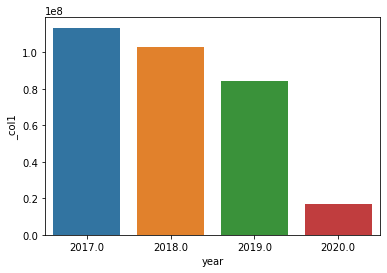

In [34]:
import numpy as np
from scipy import stats

#surpressing warning related to chained assignment of zscore to existing data frame
pd.options.mode.chained_assignment = None 

zscore = stats.zscore(df['_col1'])
print(zscore)

df['zscore']=zscore
print(df)

df_filtered= df[df['zscore'] > 0]
print(df_filtered)

sns.barplot(x="year", y="_col1", data=df_filtered)

In [112]:

import matplotlib.ticker as ticker

df2 = pd.read_sql("""
    SELECT date_trunc('day', date_parse(tpep_pickup_datetime,'%Y-%m-%d %H:%i:%s')) as day, 
    COUNT(*) as cnt,
    AVG(fare_amount) as avg_fare_amount,
    AVG(tip_amount) as avg_tip_amount
    FROM packt_serverless_analytics.chapter_3_nyc_taxi_parquet 
    GROUP BY date_trunc('day', date_parse(tpep_pickup_datetime,'%Y-%m-%d %H:%i:%s'))
    ORDER BY day ASC
""", conn)

zscore2 = stats.zscore(df2['cnt'])

df2['zscore']=zscore2
print(df2.sample(n=10, random_state=1))

df_filtered2= df2[df2['zscore'] > -1]

            day     cnt  avg_fare_amount  avg_tip_amount    zscore
1258 2020-05-29   15176        13.069402        1.607182 -2.275188
325  2017-11-08  329592        13.148264        2.032944  0.926905
930  2019-07-06  153204        13.165439        1.854691 -0.869476
1020 2019-10-04  253322        13.776985        2.301926  0.150152
1154 2020-02-15  202205        11.976112        1.946110 -0.370437
764  2019-01-21  192370        12.031329        1.827422 -0.470599
120  2017-04-17  282381        13.025113        1.832802  0.446096
65   2017-02-21  295482        12.637109        1.872478  0.579520
777  2019-02-03  220655        12.466120        2.089767 -0.182538
1124 2020-01-16  239663        12.660450        2.277753  0.011045


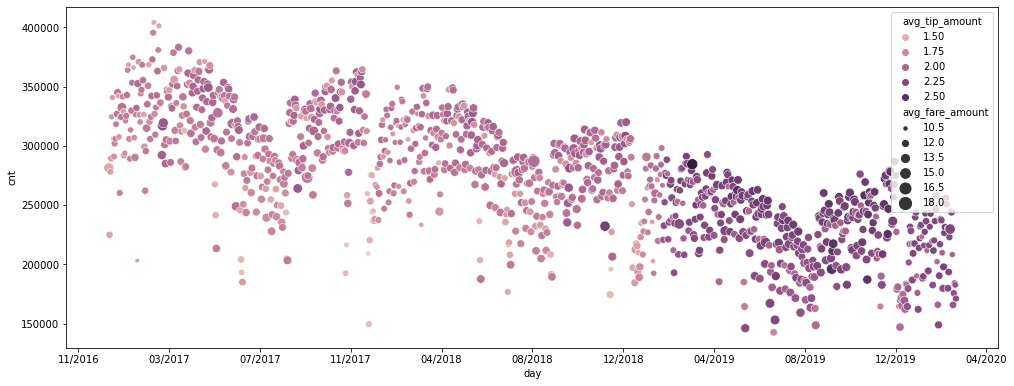

In [118]:
from matplotlib import pyplot
import matplotlib.dates as mdates

fig, ax = pyplot.subplots(figsize= (16.7, 6.27))
plot = sns.scatterplot(ax=ax, x="day", y="cnt",size="avg_fare_amount",sizes=(1, 150), hue="avg_tip_amount", data=df_filtered2)

plot.xaxis.set_major_locator(ticker.MultipleLocator(125))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))

plt.show()

In [120]:

df3=pd.read_sql("""SELECT 
     date_trunc('hour', date_parse(tpep_pickup_datetime,'%Y-%m-%d %H:%i:%s')) as hour,
     max(hour(date_parse(tpep_pickup_datetime,'%Y-%m-%d %H:%i:%s'))) as hour_val, 
     avg(date_diff('second', date_parse(tpep_pickup_datetime,'%Y-%m-%d %H:%i:%s'), 
                         date_parse(tpep_dropoff_datetime,'%Y-%m-%d %H:%i:%s'))) as duration, 
     avg(trip_distance) as trip_distance,
     avg(fare_amount) as fare_amount,
     avg(tip_amount) as tip_amount,
     count(*) as cnt
from packt_serverless_analytics.chapter_3_nyc_taxi_parquet 
WHERE year=2018
group by date_trunc('hour', date_parse(tpep_pickup_datetime,'%Y-%m-%d %H:%i:%s')) """, conn)

df3


,hour,hour_val,duration,trip_distance,fare_amount,tip_amount,cnt
0,2018-07-02 08:00:00,8,1009.684310,2.519099,11.931852,1.731169,12715
1,2018-11-29 10:00:00,10,1209.714993,2.548584,13.600474,1.945757,14147
2,2018-09-03 06:00:00,6,1089.552233,5.645264,18.938861,2.274625,2441
3,2018-12-02 02:00:00,2,1063.955934,2.700023,11.466158,1.745491,10802
4,2018-12-03 07:00:00,7,1177.815270,3.068393,12.972835,1.909739,13268
...,...,...,...,...,...,...,...
8755,2018-04-22 22:00:00,22,882.536886,3.740619,13.863771,2.054294,10153
8756,2018-12-26 14:00:00,14,1106.873513,3.073364,13.449153,1.508675,12017
8757,2018-01-31 11:00:00,11,937.676373,2.258744,11.715432,1.787988,15008
8758,2018-07-31 02:00:00,2,706.725377,3.205319,12.419664,1.426309,1726


In [121]:
df3.corr()

,hour_val,duration,trip_distance,fare_amount,tip_amount,cnt
hour_val,1.000000,0.005754,-0.343937,-0.063703,0.269898,0.691087
duration,0.005754,1.000000,-0.011371,0.012235,0.019972,0.017926
trip_distance,-0.343937,-0.011371,1.000000,0.270630,0.327299,-0.721152
fare_amount,-0.063703,0.012235,0.270630,1.000000,0.210351,-0.150395
tip_amount,0.269898,0.019972,0.327299,0.210351,1.000000,0.190958
cnt,0.691087,0.017926,-0.721152,-0.150395,0.190958,1.000000


In [122]:
df3.corr()

,hour_val,duration,trip_distance,fare_amount,tip_amount,cnt
hour_val,1.000000,0.005754,-0.343937,-0.063703,0.269898,0.691087
duration,0.005754,1.000000,-0.011371,0.012235,0.019972,0.017926
trip_distance,-0.343937,-0.011371,1.000000,0.270630,0.327299,-0.721152
fare_amount,-0.063703,0.012235,0.270630,1.000000,0.210351,-0.150395
tip_amount,0.269898,0.019972,0.327299,0.210351,1.000000,0.190958
cnt,0.691087,0.017926,-0.721152,-0.150395,0.190958,1.000000
